In [ ]:
for i in 0:num_participants
    sum += (-1)^i / factorial(i)
end

In [1]:
using Pkg
Pkg.add("Combinatorics")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.8/Project.toml`
  [861a8166] + Combinatorics v1.0.2
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
Precompiling project...
  ✓ WinReg
  ✗ RCall
  1 dependency successfully precompiled in 6 seconds. 163 already precompiled. 3 skipped during auto due to previous errors.
  1 dependency errored. To see a full report either run `import Pkg; Pkg.precompile()` or load the package


One day, my friend texted me a problem out of the blue:

How many different bracelets can be made with 8 beads, where there are 2 red beads, 2 yellow beads, 2 green beads, and 2 blue beads? 

(You must use all beads.  Bracelets that can be transformed into one another by rotation or reflection do not count as different bracelets.  That is, the bracelets have no beginning or end, no front or back. The beads are non-directed, it doesn’t matter which way they face.)

My initial strategy was to take the total number of "strings" that could be made from those beads (8! / 2^4) and then divide 8 to account for the number of possible rotational positions, then divide that by the number of axes of symmetry (8). However, my friend pointed out that this was wrong--some of these combinations are over-counted the same number of times. 

I thought that it would be easiest to work through the problem if I started with the solution. So, I wrote up some quick code in Julia to count the number of unique combinations. 

In [19]:
function is_equivalent(a, b)

    for i in 1:length(a)
        if a[i] != b[i]
            return false
        end
    end
    return true
end

is_equivalent (generic function with 1 method)

In [20]:
function is_rotationally_equivalent(a, b)
    a_temp = a
    for i in 1:length(a)
        if is_equivalent(a_temp, b)
            return true
        end
        a_temp = push!(a_temp[2:length(a)], a_temp[1])
    end
    return false

end

is_rotationally_equivalent (generic function with 1 method)

In [3]:
function is_symmetrically_and_rotationally_equivalent(a, b)
    a_reversed = reverse(a)
    if is_rotationally_equivalent(a, b)
        return true
    elseif is_rotationally_equivalent(a_reversed, b)
        return true
    else

        return false
    end
end
     
    

is_symmetrically_and_rotationally_equivalent (generic function with 1 method)

In [5]:
using Combinatorics
all_perms_list = collect(permutations(["r", "r", "g", "g", "b", "b", "y", "y"], 8))
keep_list = []
for i in 2:length(all_perms_list)
    already_in_list = false
    for j in 1:length(keep_list)
        if is_symmetrically_and_rotationally_equivalent(all_perms_list[i], keep_list[j])
            already_in_list = true
        end
    end
    if !already_in_list   
        push!(keep_list, all_perms_list[i])
    end
end
print(length(keep_list))

171

This code only took a couple of minutes to run (Julia's speed always impresses me). The result was 171, and using the combinatorics techniques I had previously, I wasn't able to reverse-engineer the answer. 

Eventually, I came across a new technique that would help me solve this problem: [Burnside's lemma](https://en.wikipedia.org/wiki/Burnside%27s_lemma) (also known as the Cauchy–Frobenius lemma). 

This lemma is given as:

$|X/G| = \frac{1}{|G|} \sum_{g \in G}|X^g|$

I'll explain some of the terms in this formula to make it more understandable:

X represents the set of all possible (non-unique) bracelets that can be made  
G represents the group of possible reflections/rotations in our situation  
|X/G| represents the number of "orbits" (or in our case, the number of unique bracelets that can be made)  
|G| represents the number items in the "group" of reflections/rotations in our situation.  
$g \in G$ indicates that the the summation iterates over all possible reflections/rotations in our situation  
$X^g$ indicates the set of elements in X that are fixed by a given group. That is, the number of possible elements  that do not change after the given reflection/rotation configuration is applied.


In order to understand how to apply burnside's lemma, let's first consider a simple situation: Imagine we want to determine how many unique combinations of 8 beads can be created, with 4 possible colors, and exactly 2 beads of each color in the string. Reverse sequences of the string count as the same string, so the following strings are equivalent:





In [21]:
using Graphs, GraphPlot
using Compose, Cairo, Fontconfig
using Colors

function create_graph(sequence, circular = true)
    colors_dict = Dict([('r', 1), ('b', 2), ('y', 3), ('g', 4)])

    membership_list = []

    for letter in sequence
        push!(membership_list, colors_dict[letter])
    end

    g = SimpleGraph(8)
    
    for i in 1:7
        add_edge!(g, i, i + 1)
    end
    if circular
        add_edge!(g, 8, 1)
    end

    nodelabel = fill("", length(8))


    nodecolor = [colorant"red", colorant"blue", colorant"yellow", colorant"green"]
    # membership color
    nodefillc = nodecolor[membership_list]
    if circular
        locs_x = [0, 1, 2, 3, 3, 2, 1, 0]
        locs_y = [2, 3, 3, 2, 1, 0, 0, 1]
    else
        locs_x = [1, 2, 3, 4, 5, 6, 7, 8]
        locs_y = repeat([0], 8)
    end



    g = gplot(g, locs_x, locs_y, nodefillc=nodefillc, )
    
    draw(PNG(sequence * ["","circular"][circular * 1 + 1] * ".png", 16cm, 16cm),g)
    g
end

create_graph (generic function with 2 methods)

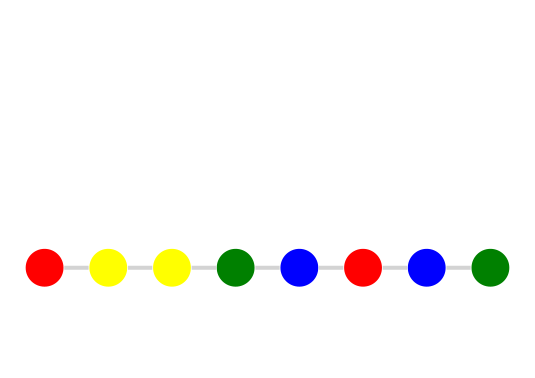

In [40]:
create_graph("ryygbrbg", false)


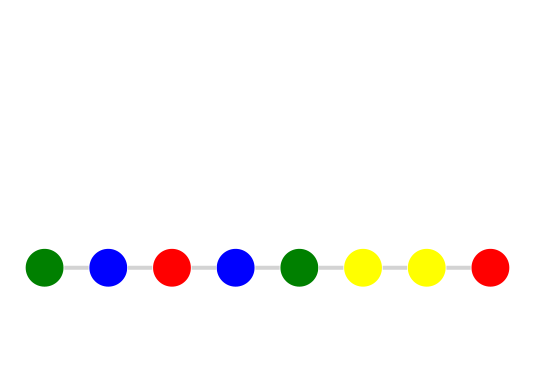

In [41]:
create_graph(reverse("ryygbrbg"), false)

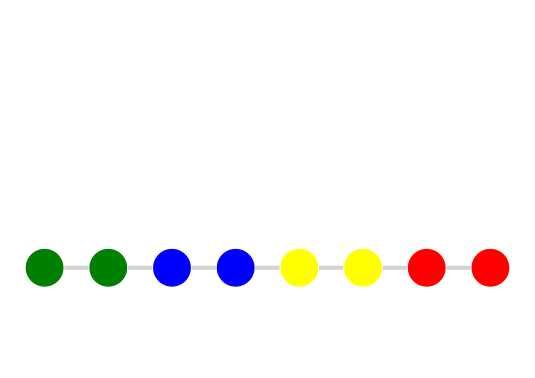

In [25]:
create_graph("ggbbyyrr", false)

In this situation, there are two groups *G*: the null group (with no reverse order) and the group which applies the action of reversing the string. The number elements fixed by each group is:

For the null group: 8! / 2^4   
For the "reversing string" group: 4!

A string can be fixed under reversal only if the first four beads are identical to the reverse of the last four beads:



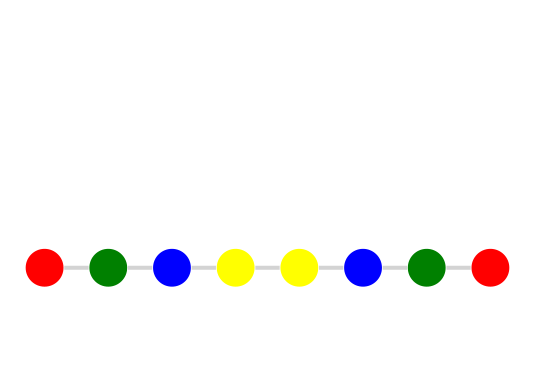

In [27]:
create_graph("rgbyybgr", false)

The first four beads determine which arrangements are fixed under the reversal group, so there are 4! ways for strings to be fixed under reversibility. 

So, $\sum_{g \in G}|X^g| = 8! / 2^4  + 4! = 2544$ 

Next, we just divide this by |G| (which is 2 in this situation) and we end up with 1272 possible strings. 

We can double check this result using Julia:

In [273]:
function is_only_symmetrically_equivalent(a, b)
    a_reversed = reverse(a)
    if is_equivalent(a, b)
        return true
    elseif is_equivalent(a_reversed, b)
        return true
    else

        return false
    end
end

is_only_symmetrically_equivalent (generic function with 1 method)

In [274]:

all_perms_list = collect(permutations(["r", "r", "g", "g", "b", "b", "y", "y"], 8))
keep_list = []
for i in 2:length(all_perms_list)
    already_in_list = false
    for j in 1:length(keep_list)
        if is_only_symmetrically_equivalent(all_perms_list[i], keep_list[j])
            already_in_list = true
        end
    end
    if !already_in_list   
        push!(keep_list, all_perms_list[i])
    end
end
print(length(keep_list))

1272

Next, let's apply burnside's lemma to our original situation: a bracelet of 8 beads, with exactly 2 of each color, and taking into account non-distinctness of rotations and reflections. Here, we have 16 groups: the null group, 7 possible rotations, 4 reflections that intersect a bead, and 4 reflections that do not intersect a bead. 

For the null group, we have 8! / 2^4 arrangements that remain "fixed". 
When rotating 1-3 or 5-7 beads, there are 0 possible ways for an arrangement to remain "fixed" with this number of beads. You would need to have all lbeads be the same color for this to be valid. 

however, when rotating 4 beads, it is possible for an arrangement to remain "fixed" if the last 4 beads repeat the first 4 beads. So, there are 4! fixed arrangments for that rotation group. 





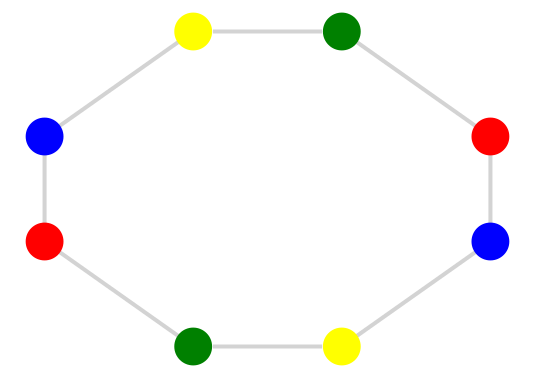

In [29]:
create_graph("rgybrgyb", true) ## RGYBRGYB plot

For each of the 8 reflections, there are 4! arrangements that remain fixed across that arrangement. 

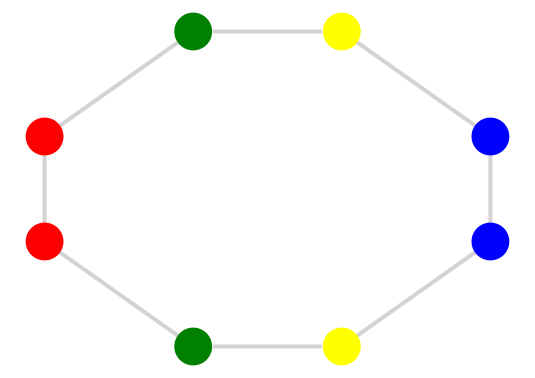

In [31]:
create_graph("rgybbygr", true) ## RGYBRGYB plot

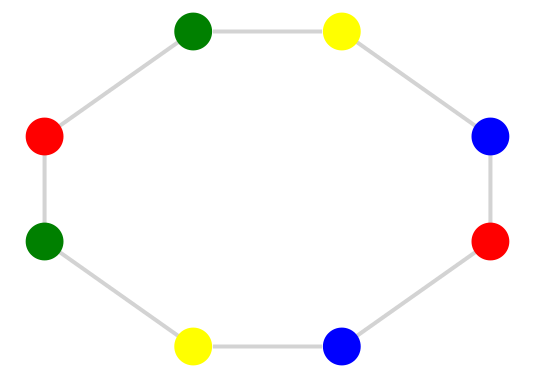

In [39]:
create_graph("gybrbygr", true) ## RGYBRGYB plot

In [38]:
using Plots

create_graph("gybrbygr", true) ## RGYBRGYB plot
plot!(0, 1)

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]

signal (2): Interrupt: 2
in expression starting at none:1


LoadError: Failed to precompile Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] to /Users/zacharyclement/.julia/compiled/v1.8/Plots/jl_TVq3hx.

In [37]:
import Pkg; Pkg.add("Plots")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed x265_jll ───────────────────── v3.5.0+0
   Installed GR_jll ─────────────────────── v0.71.7+0
   Installed LERC_jll ───────────────────── v3.0.0+1
   Installed libfdk_aac_jll ─────────────── v2.0.2+0
   Installed StatisticalTraits ──────────── v1.1.0
   Installed Xorg_xkbcomp_jll ───────────── v1.4.2+4
   Installed JpegTurbo_jll ──────────────── v2.1.91+0
   Installed Opus_jll ───────────────────── v1.3.2+0
   Installed RelocatableFolders ─────────── v1.0.0
   Installed Grisu ──────────────────────── v1.0.2
   Installed TimerOutputs ───────────────── v0.5.22
   Installed JLSO ───────────────────────── v2.7.0
   Installed Contour ────────────────────── v0.6.2
   Installed Highlights ─────────────────── v0.5.2
   Installed RCall ──────────────────────── v0.13.14
   Installed Xorg_xcb_util_wm_jll ───────── v0.4.1+1
   Installed StaticArrays ───────────────── v1.5.16
   Installed Xorg_

   Installed MakieCore ──────────────────── v0.6.2
   Installed Xorg_xkeyboard_config_jll ──── v2.27.0+4
   Installed RecipesBase ────────────────── v1.3.3
   Installed Xorg_libXfixes_jll ─────────── v5.0.3+4
   Installed Xorg_libXrandr_jll ─────────── v1.5.2+4
   Installed URIs ───────────────────────── v1.4.2
   Installed XGBoost ────────────────────── v2.2.5
   Installed LAME_jll ───────────────────── v3.100.1+0
   Installed FilePathsBase ──────────────── v0.9.20
   Installed libvorbis_jll ──────────────── v1.3.7+1
   Installed Libglvnd_jll ───────────────── v1.6.0+0
   Installed ForwardDiff ────────────────── v0.10.35
   Installed FillArrays ─────────────────── v0.11.9
   Installed LearnBase ──────────────────── v0.4.1
   Installed QuadGK ─────────────────────── v2.8.1
   Installed BSON ───────────────────────── v0.3.6
   Installed Observables ────────────────── v0.5.4
   Installed Unzip ──────────────────────── v0.2.0
   Installed Lathe ──────────────────────── v0.1.6
   Installed

  [9abbd945] - Profile
  [05823500] + OpenLibm_jll v0.8.1+0
        Info Packages marked with ⌃ and ⌅ have new versions available, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated -m`
    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/e32a90da027ca45d84678b826fffd3110bb3fc90/build.log`
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/62f417f6ad727987c755549e9cd88c46578da562/build.log`
    Building RCall ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/2c0ffd39860c9a48259a0f57214ced2024ab63bc/build.log`


LoadError: Error building `RCall`: 
ERROR: could not load library "/Volumes/SanDisk/opt/anaconda3/lib/R/lib/libR.dylib"
dlopen(/Volumes/SanDisk/opt/anaconda3/lib/R/lib/libR.dylib, 0x0001): Library not loaded: @rpath/libreadline.6.2.dylib
  Referenced from: <185433D7-8B40-31AA-8BD9-465D23C57257> /Volumes/SanDisk/opt/anaconda3/lib/R/lib/libR.dylib
  Reason: tried: '/Volumes/SanDisk/opt/anaconda3/lib/R/lib/../../libreadline.6.2.dylib' (no such file), '/Volumes/SanDisk/opt/anaconda3/lib/R/lib/../../libreadline.6.2.dylib' (no such file), '/Applications/Julia-1.8.app/Contents/Resources/julia/lib/julia/libreadline.6.2.dylib' (no such file), '/Applications/Julia-1.8.app/Contents/Resources/julia/lib/libreadline.6.2.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS@rpath/libreadline.6.2.dylib' (no such file), '/Volumes/SanDisk/opt/anaconda3/lib/R/lib/../../libreadline.6.2.dylib' (no such file), '/Volumes/SanDisk/opt/anaconda3/lib/R/lib/../../libreadline.6.2.dylib' (no such file), '/Applications/Julia-1.8.app/Contents/Resources/julia/lib/julia/libreadline.6.2.dylib' (no such file), '/Applications/Julia-1.8.app/Contents/Resources/julia/lib/libreadline.6.2.dylib' (no such file), '/usr/local/lib/libreadline.6.2.dylib' (no such file), '/usr/lib/libreadline.6.2.dylib' (no such file, not in dyld cache)
ERROR: LoadError: Try adding /Volumes/SanDisk/opt/anaconda3/lib/R/lib to the "LD_LIBRARY_PATH" environmental variable and restarting Julia.
Stacktrace:
 [1] error(s::String)
   @ Base ./error.jl:35
 [2] validate_libR(libR::String)
   @ Main ~/.julia/packages/RCall/Wyd74/deps/setup.jl:26
 [3] locate_libR(Rhome::SubString{String})
   @ Main ~/.julia/packages/RCall/Wyd74/deps/setup.jl:43
 [4] top-level scope
   @ ~/.julia/packages/RCall/Wyd74/deps/build.jl:58
 [5] include(fname::String)
   @ Base.MainInclude ./client.jl:476
 [6] top-level scope
   @ none:5
in expression starting at /Users/zacharyclement/.julia/packages/RCall/Wyd74/deps/build.jl:11

caused by: could not load library "/Volumes/SanDisk/opt/anaconda3/lib/R/lib/libR.dylib"
dlopen(/Volumes/SanDisk/opt/anaconda3/lib/R/lib/libR.dylib, 0x0001): Library not loaded: @rpath/libreadline.6.2.dylib
  Referenced from: <185433D7-8B40-31AA-8BD9-465D23C57257> /Volumes/SanDisk/opt/anaconda3/lib/R/lib/libR.dylib
  Reason: tried: '/Volumes/SanDisk/opt/anaconda3/lib/R/lib/../../libreadline.6.2.dylib' (no such file), '/Volumes/SanDisk/opt/anaconda3/lib/R/lib/../../libreadline.6.2.dylib' (no such file), '/Applications/Julia-1.8.app/Contents/Resources/julia/lib/julia/libreadline.6.2.dylib' (no such file), '/Applications/Julia-1.8.app/Contents/Resources/julia/lib/libreadline.6.2.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS@rpath/libreadline.6.2.dylib' (no such file), '/Volumes/SanDisk/opt/anaconda3/lib/R/lib/../../libreadline.6.2.dylib' (no such file), '/Volumes/SanDisk/opt/anaconda3/lib/R/lib/../../libreadline.6.2.dylib' (no such file), '/Applications/Julia-1.8.app/Contents/Resources/julia/lib/julia/libreadline.6.2.dylib' (no such file), '/Applications/Julia-1.8.app/Contents/Resources/julia/lib/libreadline.6.2.dylib' (no such file), '/usr/local/lib/libreadline.6.2.dylib' (no such file), '/usr/lib/libreadline.6.2.dylib' (no such file, not in dyld cache)
Stacktrace:
 [1] dlopen(s::String, flags::UInt32; throw_error::Bool)
   @ Base.Libc.Libdl ./libdl.jl:117
 [2] dlopen (repeats 2 times)
   @ ./libdl.jl:116 [inlined]
 [3] validate_libR(libR::String)
   @ Main ~/.julia/packages/RCall/Wyd74/deps/setup.jl:16
 [4] locate_libR(Rhome::SubString{String})
   @ Main ~/.julia/packages/RCall/Wyd74/deps/setup.jl:43
 [5] top-level scope
   @ ~/.julia/packages/RCall/Wyd74/deps/build.jl:58
 [6] include(fname::String)
   @ Base.MainInclude ./client.jl:476
 [7] top-level scope
   @ none:5

Now, we can put this together:

$\frac{1}{|G|} \sum_{g \in G}|X^g| = \frac{8! / 2^4  + 4! + 8 * 4!}{  16} = 2736 / 16 = 171$ 

So, $\frac{1}{|G|} \sum_{g \in G}|X^g| = 2736 / 16 = 171$


This corresponds to our brute-force solution. 



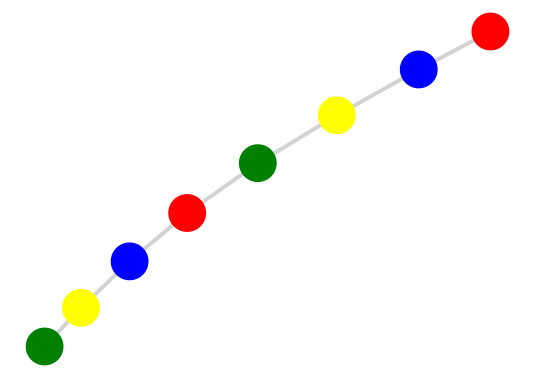

In [289]:
using Graphs, GraphPlot
using Compose, Cairo, Fontconfig
using Colors

g = SimpleGraph(8)
for i in 1:7
    add_edge!(g, i, i + 1)
end
#add_edge!(g, 8, 1)

nodelabel = fill("", length(8))

membership = [1, 2, 3, 4, 1, 2, 3, 4]

nodecolor = [colorant"red", colorant"blue", colorant"yellow", colorant"green"]
# membership color
nodefillc = nodecolor[membership]

locs_x = [0, 2, 3, 2]
locs_y = [0, -1, 1, 0]

nodestrokelw = [0, 0, 0, 0, 0]

g = gplot(g, nodefillc=nodefillc)#, locs_x, locs_y, #nodelabel=nodelabel, 
    #nodestrokec = "black", nodestrokelw = nodestrokelw, NODESIZE = .15)
draw(PNG("smoking.png", 16cm, 16cm),g)
g

In [286]:
import Pkg; Pkg.add("Colors")

   Resolving package versions...
    Updating `~/.julia/environments/v1.8/Project.toml`
  [5ae59095] + Colors v0.12.10
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [275]:
factorial(8) / 2^4 + factorial(4) * 9

2736.0

In [234]:
using Combinatorics
all_permutations = permutations(["r", "r", "g", "g", "b", "b"], 6)

Combinatorics.Permutations{Vector{String}}(["r", "r", "g", "g", "b", "b"], 6)

In [243]:
all_perms_list

720-element Vector{Vector{String}}:
 ["r", "r", "g", "g", "b", "b"]
 ["r", "r", "g", "g", "b", "b"]
 ["r", "r", "g", "b", "g", "b"]
 ["r", "r", "g", "b", "b", "g"]
 ["r", "r", "g", "b", "g", "b"]
 ["r", "r", "g", "b", "b", "g"]
 ["r", "r", "g", "g", "b", "b"]
 ["r", "r", "g", "g", "b", "b"]
 ["r", "r", "g", "b", "g", "b"]
 ["r", "r", "g", "b", "b", "g"]
 ["r", "r", "g", "b", "g", "b"]
 ["r", "r", "g", "b", "b", "g"]
 ["r", "r", "b", "g", "g", "b"]
 ⋮
 ["b", "b", "g", "r", "r", "g"]
 ["b", "b", "g", "r", "g", "r"]
 ["b", "b", "g", "r", "r", "g"]
 ["b", "b", "g", "r", "g", "r"]
 ["b", "b", "g", "g", "r", "r"]
 ["b", "b", "g", "g", "r", "r"]
 ["b", "b", "g", "r", "r", "g"]
 ["b", "b", "g", "r", "g", "r"]
 ["b", "b", "g", "r", "r", "g"]
 ["b", "b", "g", "r", "g", "r"]
 ["b", "b", "g", "g", "r", "r"]
 ["b", "b", "g", "g", "r", "r"]

In [251]:
keep_list_symmetry = [join(x) for x in keep_list]

48-element Vector{String}:
 "rrggbb"
 "rrgbgb"
 "rrgbbg"
 "rrbggb"
 "rrbgbg"
 "rrbbgg"
 "rgrgbb"
 "rgrbgb"
 "rgrbbg"
 "rggrbb"
 "rggbrb"
 "rggbbr"
 "rgbrgb"
 ⋮
 "grbbrg"
 "ggrrbb"
 "ggrbrb"
 "ggbrrb"
 "gbrrgb"
 "gbrrbg"
 "gbrgrb"
 "gbgrrb"
 "brrggb"
 "brgrgb"
 "brggrb"
 "bgrrgb"

In [245]:
all_perms_list = collect(permutations(["r", "r", "g", "g", "b", "b"], 6))
keep_list = []
for i in 2:length(all_perms_list)
    already_in_list = false
    for j in 1:length(keep_list)
        if is_equivalent(all_perms_list[i], keep_list[j])
            already_in_list = true
        end
    end
    if !already_in_list   
        push!(keep_list, all_perms_list[i])
    end
end
print(length(keep_list))

90

In [249]:
keep_list_no_symmetry = [join(x) for x in keep_list]

90-element Vector{String}:
 "rrggbb"
 "rrgbgb"
 "rrgbbg"
 "rrbggb"
 "rrbgbg"
 "rrbbgg"
 "rgrgbb"
 "rgrbgb"
 "rgrbbg"
 "rggrbb"
 "rggbrb"
 "rggbbr"
 "rgbrgb"
 ⋮
 "bggrrb"
 "bggrbr"
 "bggbrr"
 "bgbrrg"
 "bgbrgr"
 "bgbgrr"
 "bbrrgg"
 "bbrgrg"
 "bbrggr"
 "bbgrrg"
 "bbgrgr"
 "bbggrr"

In [256]:
double_counted_list = []
for x in keep_list_no_symmetry 
    if !(x in keep_list_symmetry)
        push!(double_counted_list, x)
    end
end


In [265]:
single_counted_list = []
for x in keep_list_symmetry 
    if !(reverse(x) in double_counted_list)
        push!(single_counted_list, x)
    end
end
single_counted_list

6-element Vector{Any}:
 "rgbbgr"
 "rbggbr"
 "grbbrg"
 "gbrrbg"
 "brggrb"
 "bgrrgb"

In [262]:
reverse("rrbbgg") in keep_list_symmetry

false

In [263]:
reverse("rrbbgg")

"ggbbrr"

In [261]:
factorial(6) / factorial(4) / factorial(2) * factorial(4) / factorial(2) / 2

90.0

In [153]:
using Combinatorics
all_permutations = permutations(["a", "a", "b", "b", "c", "c", "d", "d"], 8)

Combinatorics.Permutations{Vector{String}}(["a", "a", "b", "b", "c", "c", "d", "d"], 8)

In [160]:
using Combinatorics
all_permutations = permutations(["a", "a", "b", "b", "c", "c", "d", "d", "e", "e"], 10)

Combinatorics.Permutations{Vector{String}}(["a", "a", "b", "b", "c", "c", "d", "d", "e", "e"], 10)

In [161]:

all_perms_list = collect(all_permutations)

3628800-element Vector{Vector{String}}:
 ["a", "a", "b", "b", "c", "c", "d", "d", "e", "e"]
 ["a", "a", "b", "b", "c", "c", "d", "d", "e", "e"]
 ["a", "a", "b", "b", "c", "c", "d", "e", "d", "e"]
 ["a", "a", "b", "b", "c", "c", "d", "e", "e", "d"]
 ["a", "a", "b", "b", "c", "c", "d", "e", "d", "e"]
 ["a", "a", "b", "b", "c", "c", "d", "e", "e", "d"]
 ["a", "a", "b", "b", "c", "c", "d", "d", "e", "e"]
 ["a", "a", "b", "b", "c", "c", "d", "d", "e", "e"]
 ["a", "a", "b", "b", "c", "c", "d", "e", "d", "e"]
 ["a", "a", "b", "b", "c", "c", "d", "e", "e", "d"]
 ["a", "a", "b", "b", "c", "c", "d", "e", "d", "e"]
 ["a", "a", "b", "b", "c", "c", "d", "e", "e", "d"]
 ["a", "a", "b", "b", "c", "c", "e", "d", "d", "e"]
 ⋮
 ["e", "e", "d", "d", "c", "c", "b", "a", "a", "b"]
 ["e", "e", "d", "d", "c", "c", "b", "a", "b", "a"]
 ["e", "e", "d", "d", "c", "c", "b", "a", "a", "b"]
 ["e", "e", "d", "d", "c", "c", "b", "a", "b", "a"]
 ["e", "e", "d", "d", "c", "c", "b", "b", "a", "a"]
 ["e", "e", "d", "d",

In [162]:
keep_list = [all_perms_list[1]]


1-element Vector{Vector{String}}:
 ["a", "a", "b", "b", "c", "c", "d", "d", "e", "e"]

In [ ]:
for i in 2:length(all_perms_list)
    already_in_list = false
    for j in 1:length(keep_list)
        if is_symmetrically_equivalent(all_perms_list[i], keep_list[j])
            already_in_list = true
        end
    end
    if !already_in_list   
        push!(keep_list, all_perms_list[i])
    end
end

In [ ]:
keep_list

In [ ]:
["r", "g", "g", "b", "r", "b"] ?rbrggb


"r", "g", "b", "r", "b", "g"]


["r", "g", "b", "g", "r", "b"] ?rbrgbg

 



In [159]:
171 / 3


57.0

In [125]:
is_symmetrically_equivalent(all_perms_list[i], keep_list[j])

In [56]:
reverse(a)

8-element Vector{String}:
 "d"
 "d"
 "c"
 "c"
 "b"
 "b"
 "a"
 "a"

In [40]:
a_temp = push!(a[2:8], a[1])

8-element Vector{String}:
 "a"
 "b"
 "b"
 "c"
 "c"
 "d"
 "d"
 "a"

In [31]:
a[2:8] + a[1]

LoadError: MethodError: no method matching +(::Vector{String}, ::String)
[0mClosest candidates are:
[0m  +(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at operators.jl:591
[0m  +(::Array, [91m::Array...[39m) at arraymath.jl:12
[0m  +(::Array, [91m::SparseArrays.AbstractSparseMatrixCSC[39m) at /Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/SparseArrays/src/sparsematrix.jl:1833
[0m  ...

In [33]:
x = true

true

In [45]:
reverse(a)

8-element Vector{String}:
 "d"
 "d"
 "c"
 "c"
 "b"
 "b"
 "a"
 "a"

In [2]:
import Pkg; Pkg.add("Primes")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.8/Project.toml`
  [27ebfcd6] + Primes v0.5.3
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [24]:
using Primes
my_factor = Set([i[1] for i in collect(factor(18))])

Set{Int64} with 2 elements:
  2
  3

In [30]:
length(union!(my_factor, [3, 2, 5]))

3

In [23]:
my_factor

LoadError: UndefVarError: set not defined

In [46]:
?factor


search: factor factorial my_factor eachfactor prodfactors TaskFailedException



```
factor(n::Integer) -> Primes.Factorization
```

Compute the prime factorization of an integer `n`. The returned object, of type `Factorization`, is an associative container whose keys correspond to the factors, in sorted order. The value associated with each key indicates the multiplicity (i.e. the number of times the factor appears in the factorization).

```julia
julia> factor(100)
2^2 ⋅ 5^2
```

For convenience, a negative number `n` is factored as `-1*(-n)` (i.e. `-1` is considered to be a factor), and `0` is factored as `0^1`:

```julia
julia> factor(-9)
-1 ⋅ 3^2

julia> factor(0)
0

julia> collect(factor(0))
1-element Array{Pair{Int64,Int64},1}:
 0=>1
```

---

```
factor(ContainerType, n::Integer) -> ContainerType
```

Return the factorization of `n` stored in a `ContainerType`, which must be a subtype of `AbstractDict` or `AbstractArray`, a `Set`, or an `BitSet`.

```julia
julia> factor(DataStructures.SortedDict, 100)
DataStructures.SortedDict{Int64,Int64,Base.Order.ForwardOrdering} with 2 entries:
  2 => 2
  5 => 2
```

When `ContainerType <: AbstractArray`, this returns the list of all prime factors of `n` with multiplicities, in sorted order.

```julia
julia> factor(Vector, 100)
4-element Array{Int64,1}:
 2
 2
 5
 5

julia> prod(factor(Vector, 100)) == 100
true
```

When `ContainerType == Set`, this returns the distinct prime factors as a set.

```julia
julia> factor(Set, 100)
Set([2,5])
```


In [1]:
using Primes
function is_relative_prime(x, y)
    x_factors = factor(Set, x)
    y_factors = factor(Set,y)
    for factor in y_factors
        if factor in x_factors
            return false
        end
    end
    ## none of them had a match
    return true
    
    
end


is_relative_prime (generic function with 1 method)

In [2]:
function euler_totient(x)
    output_sum = 0
    for i in 1:x
        if is_relative_prime(i, x)
            output_sum += 1
        end
    end
    return output_sum
        
end


euler_totient (generic function with 1 method)

In [5]:
using Combinatorics
function get_factors(x)
    prime_factors = factor(Vector, x)
    all_prime_factors = vcat(prime_factors, fill(1, length(prime_factors))) ## add 1s so smaller numbers are included

    factor_list = [prod(i) for i in combinations(all_prime_factors, length(prime_factors))]
    return Set(factor_list)

end

get_factors (generic function with 1 method)

In [6]:
get_factors(12)

Set{Int64} with 6 elements:
  12
  1
  4
  6
  2
  3

In [7]:
num_beads = 4
necklace_size = 4

sum = 0

for d in get_factors(num_beads)
    sum = sum + euler_totient(d) * necklace_size ^ (num_beads / d)
end

sum = sum / num_beads
print(sum)


70.0

In [8]:
function get_number_necklaces(n, k)
    sum = 0

    for d in get_factors(n)
        sum = sum + euler_totient(d) * k ^ (n / d)
    end

    sum = sum / n
end

get_number_necklaces (generic function with 1 method)

You can check your work here https://oeis.org/A000031

In [9]:
function get_number_bracelets(n, k)
    if round(n / 2) == n / 2
        return get_number_necklaces(n, k) / 2 + (k + 1) * k^(n / 2)/4
    else
        return get_number_necklaces(n, k) / 2 +  k^((n+1) / 2)/2
    end
end


get_number_bracelets (generic function with 1 method)

In [36]:
get_number_necklaces(12, 2)

352.0

In [10]:
for i in 1:12
    println(get_number_necklaces(i, 12))
end

12.0
78.0
584.0
5226.0
49776.0
498004.0
5.11884e6
5.3750346e7
5.7330932e8
6.191761368e9
6.7546215528e10
7.43008623292e11


In [186]:
(get_number_bracelets(8, 4) 
- 4 ### bracelets of all of each of the 4 colors
- 6 * get_number_bracelets(8, 2)
- 4 * get_number_bracelets(8, 3)

)

2259.0

In [184]:
get_number_bracelets(5, 2)

8.0

In [78]:
tril!(prime_factors * transpose(prime_factors))

LoadError: UndefVarError: tril! not defined

Burnside's lemma takes into account rotations, and it also works for reflections. 

https://math.stackexchange.com/questions/3246995/number-of-bracelets-with-6-white-3-blue-and-5-red-beads?rq=1

In [228]:
(factorial(8) / (2 ^ 4) + factorial(4)  * 9) / 16

171.0

In [230]:
(factorial(6) / (2 ^ 3) + factorial(3)  * 7) / 12

11.0

In [227]:
24 * 171 - factorial(8) / (2 ^ 4) - factorial(4)  * 17 * 3

360.0

In [222]:
factor(Vector, 1992)


5-element Vector{Int64}:
  2
  2
  2
  3
 83

In [210]:
?combinations


search: combinations all_combinations multiset_combinations CoolLexCombinations



```
combinations(a, n)
```

Generate all combinations of `n` elements from an indexable object `a`. Because the number of combinations can be very large, this function returns an iterator object. Use `collect(combinations(a, n))` to get an array of all combinations.

---

```
combinations(a)
```

Generate combinations of the elements of `a` of all orders. Chaining of order iterators is eager, but the sequence at each order is lazy.


In [213]:
factorial(14) / factorial(14 - 6) / factorial(6) * factorial(8) / factorial(5) / factorial(3)

168168.0

In [214]:
factorial(14) / factorial(14 - 3) / factorial(3) * factorial(11) / factorial(6) / factorial(5)

168168.0

In [215]:
factorial(8) / 2 ^4

2520.0

In [216]:
factorial(8) / factorial(6) * factorial(6) / factorial(4) * factorial(4) / factorial(2) / 2^3

2520.0

## How many possible chords are there, accounting for transposition?

1: 1  
2: 6  
3: 19  
4: 43  
5: 66  
6: 80  
7: 66  
8: 43  
9: 19  
10: 6  
11: 1  
12: 1

In [46]:
(1 + 6 + 19 + 43 + 66) * 2 + 80 + 1

351

In [12]:
function comb(n, k)
    return factorial(n) / factorial(k) / factorial(n - k)
end

comb (generic function with 1 method)

In [ ]:
## 2/10
(comb(12, 2) + 6)/ 12 # at 6 o clock, there are 6 different fixed points

In [14]:
## 3 / 9
(comb(12, 3) + 4*2)/ 12
## 4 and 8 o clock both have 4 fixed

19.0

In [46]:
## 4/8
(comb(12, 4) + 
    comb(6, 2) + #rotation at half
    3*2 #at 3 and 9 o clock there are 3 possible combinations
    )/ 12

43.0

In [37]:
## 5/7
(comb(12, 5))/ 12 ## no way for there to be any fixed points beyond the null

66.0

In [49]:
comb(12, 6) / 12

77.0

In [48]:
## 6
(comb(12, 6) + 
    2 * 2 + #2, and 10 o clock both have 2 choices
    comb(4, 2) * 2 + #4 and 8 o clock rotations can distribute 1/3 the beads (2) among 4 possible slots
    
    comb(6, 3) # 6 o clock can distribute 3 beads among 6 possible slots
    )/ 12

80.0

In [56]:
sum = 0 ## chord of 1
for i in 1:12
    current_number = factorial(11) / factorial(i - 1) / factorial(11 - i + 1)
    sum += current_number
    println(i, " ", current_number)
end
print(sum)

1 1.0
2 11.0
3 55.0
4 165.0
5 330.0
6 462.0
7 462.0
8 330.0
9 165.0
10 55.0
11 11.0
12 1.0
2048.0

If there were 4 different notes  
0. 1 option  
1. 1 options.  
2. 2 options
3. 1 option
4. 1 option

In [42]:
get_number_necklaces(4, 2)

6.0

If there were 5 notes:  

0. 1 option  
1. 1 option   
2. 4 options  
3. 4 options  
4. 1 option    
5.  1 option  


In [43]:
get_number_necklaces(5, 2)

8.0

In [29]:
using Combinatorics
n_played = 1
n_notes = 12
perms = permutations(
            vcat(repeat([true], n_played), repeat([false], n_notes - n_played)), 
            n_notes)

Combinatorics.Permutations{Vector{Bool}}(Bool[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 12)

In [30]:
length(perms)

479001600

In [31]:
output_list = []
for arrangement in perms
    if !( arrangement in output_list)
        push!(output_list, arrangement)
    end
        
end
output_list

12-element Vector{Any}:
 Bool[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 Bool[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 Bool[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 Bool[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
 Bool[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
 Bool[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
 Bool[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
 Bool[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
 Bool[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
 Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
 Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
 Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [28]:
collect(combinations([1, 2, 3], 3))

1-element Vector{Vector{Int64}}:
 [1, 2, 3]

In [42]:
function get_all_perms_list(n_played, n_notes = 12)
    perms = permutations(
                vcat(repeat([true], n_played - 1), repeat([false], n_notes - n_played)), 
                n_notes - 1)
    output_list = []
    for arrangement in perms
        if !( arrangement in output_list)
            push!(output_list, arrangement)
        end

    end
    for i in 1:length(output_list)
        push!(output_list[i], true) #endlways end with a note played
        
    end
    return output_list
end

get_all_perms_list (generic function with 2 methods)

In [43]:
get_all_perms_list(2, 5)

4-element Vector{Any}:
 Bool[1, 0, 0, 0, 1]
 Bool[0, 1, 0, 0, 1]
 Bool[0, 0, 1, 0, 1]
 Bool[0, 0, 0, 1, 1]

In [44]:
using Combinatorics
function get_num_note_combinations(n_played)
    all_perms_list = get_all_perms_list(n_played)
    keep_list = []
    for i in 2:length(all_perms_list)
        already_in_list = false
        for j in 1:length(keep_list)
            if is_rotationally_equivalent(all_perms_list[i], keep_list[j])
                already_in_list = true
            end
        end
        if !already_in_list   
            push!(keep_list, all_perms_list[i])
        end
    end
    println(n_played, ": ", length(keep_list))
end

get_num_note_combinations (generic function with 1 method)

In [45]:
for i in 2:12
    get_num_note_combinations(i)
end

2: 6
3: 19
4: 43
5: 66
6: 80
7: 66
8: 43
9: 19


LoadError: InterruptException: